In [58]:
import PIL.Image
import numpy as np
from typing import Union
from glob import glob
import pandas as pd
import os
#from treys import Card
from termcolor import colored
#from utils import eval_listof_games , debug_listof_games, save_results , load_results
import scipy

In [59]:
import skimage.io
import matplotlib.pyplot as plt
from skimage.segmentation import flood, flood_fill
from skimage import morphology
from skimage import feature
from skimage.morphology import closing, opening, disk, square
from skimage import filters
import cv2 as cv

In [60]:
from helper import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Note: histogram equalization really makes it easier

### Strategie


Use setup data to isolate numbers/letters and symbols and define the selection features (Fourier might be good, as there is only 1 way to write 1 symbol so quite deterministic, and invariability to rotation).

Proceed by "player space"

- cards
    - we must go for the numbers/letters and signs just under, as cards hidden behind others cannot be classified using the whole card.
    - once we have all the contours"
        - quick control of the possibility that a card is hidden (high fourier frequency ?) or a "dressed/ace" ? The come back with less frequencies ?
        - find the contours of interest by looking for which contour are the closest to target contours (experiment a bit with set up cards)?
    
- chips
    - Separate everything given the color (red, black, blue, green, white). 
    - get them when we get the rest

Import all train data

In [56]:
path_data = 'data/train'
i = 0
file = os.path.join(path_data, f"train_{str(i).zfill(2)}.jpg")
images = []

while os.path.exists(file):
    im = skimage.io.imread(file)
    images.append(im)
    i += 1
    file = os.path.join(path_data, f"train_{str(i).zfill(2)}.jpg")

Subsample to 2 images for now

In [10]:
images = [images[1], images[4], images[8], images[22]]

## Histogram equalization

In [11]:
equalized = []
for image in images:
    equalized.append(hist_eq(image))

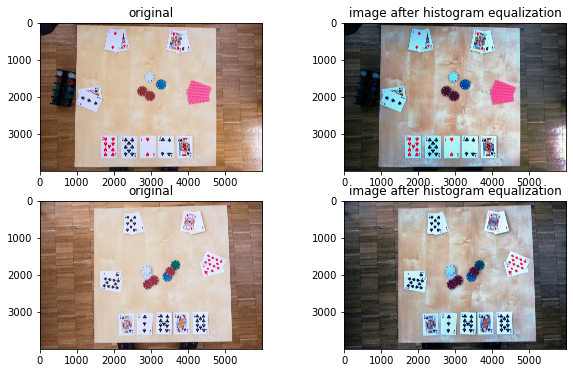

In [12]:
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize=(10,6))
for ax, image, edge in zip(axes, images, equalized):
    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('original')
    ax[1].imshow(edge, cmap=plt.cm.gray)
    ax[1].set_title('image after histogram equalization')
plt.show()

## Plot RGB channels

In [13]:
print(np.min([equalized[0]]), np.max(equalized[0]))

0.0009179709584131311 0.999931981348209


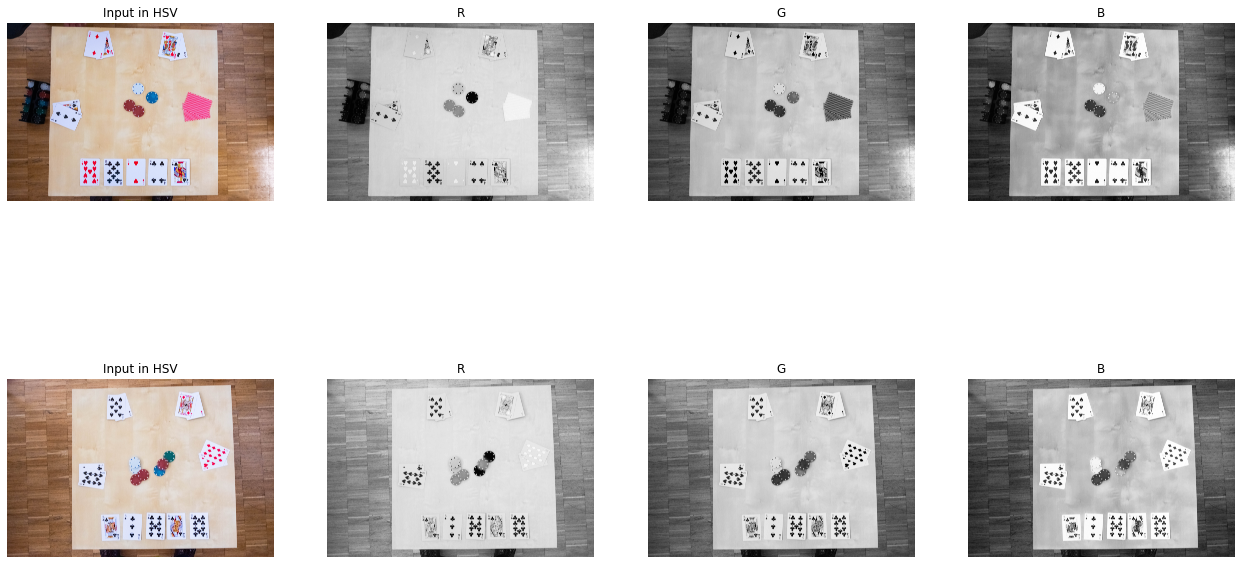

In [14]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(22, 12))

for i in range(2):
    ax[i,0].imshow(images[i])
    ax[i,0].set_title('Input in HSV')
    ax[i,0].axis('off')
    
    ax[i,1].imshow(images[i][:,:,0], cmap = 'gray')
    ax[i,1].set_title('R')
    ax[i,1].axis('off')
    
    ax[i,2].imshow(images[i][:,:,1], cmap = 'gray')
    ax[i,2].set_title('G')
    ax[i,2].axis('off')
    
    ax[i,3].imshow(images[i][:,:,2], cmap = 'gray')
    ax[i,3].set_title('B')
    ax[i,3].axis('off')
    ascii

## Plot hsv channels

In [15]:
equalized_hsv = [skimage.color.rgb2hsv(equalized[0]), skimage.color.rgb2hsv(equalized[1])]

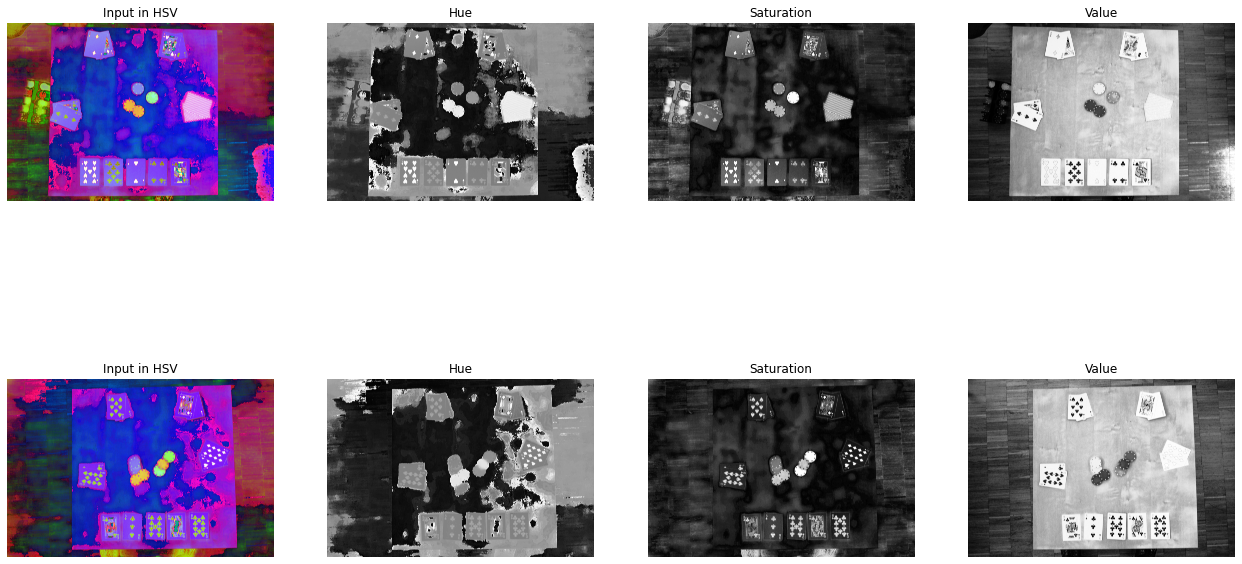

In [16]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(22, 12))

for i in range(2):
    ax[i,0].imshow(equalized_hsv[i])
    ax[i,0].set_title('Input in HSV')
    ax[i,0].axis('off')
    
    ax[i,1].imshow(equalized_hsv[i][:,:,0], cmap = 'gray')
    ax[i,1].set_title('Hue')
    ax[i,1].axis('off')
    
    ax[i,2].imshow(equalized_hsv[i][:,:,1], cmap = 'gray')
    ax[i,2].set_title('Saturation')
    ax[i,2].axis('off')
    
    ax[i,3].imshow(equalized_hsv[i][:,:,2], cmap = 'gray')
    ax[i,3].set_title('Value')
    ax[i,3].axis('off')
    ascii

## Isolation of table

In [17]:
binary = []
for eq in equalized:
    binary.append(binarization(eq))

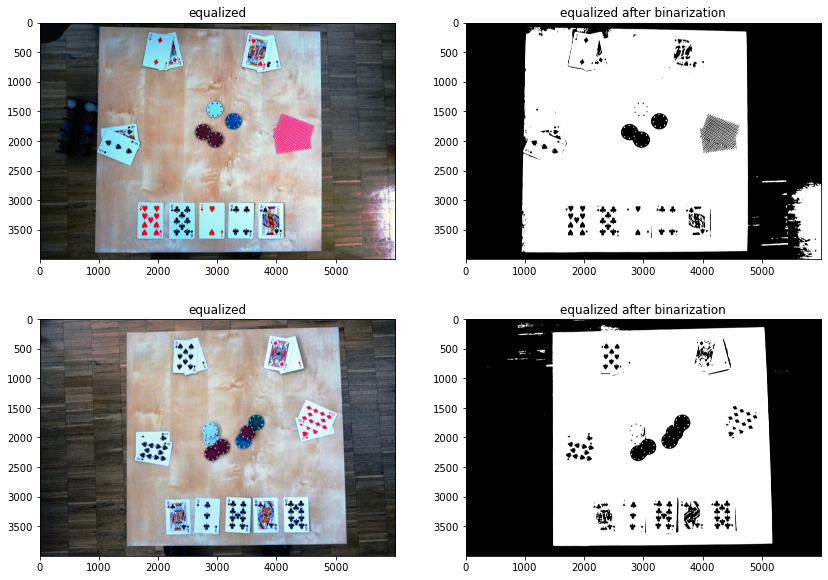

In [18]:
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize=(14,10))
for ax, image, map_ in zip(axes, equalized, binary):
    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('equalized')
    ax[1].imshow(map_, cmap=plt.cm.gray)
    ax[1].set_title('equalized after binarization')
plt.show()

In [19]:
masks, cropped_img = [], []
for image, bin_img in zip(images, binary):
    mask, crop = crop_table_from_binary(image, bin_img)
    masks.append(mask)
    cropped_img.append(crop)

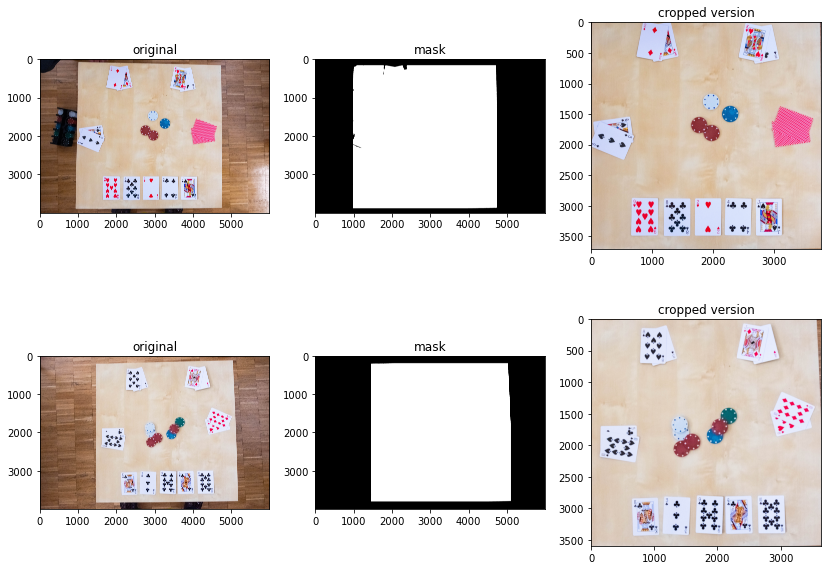

In [20]:
fig, axes = plt.subplots(ncols = 3, nrows = 2, figsize=(14,10))
for ax, image, mask, crop in zip(axes, images, masks, cropped_img):
    ax[0].imshow(image)
    ax[0].set_title('original')
    ax[1].imshow(mask, cmap=plt.cm.gray)
    ax[1].set_title('mask')
    ax[2].imshow(crop)
    ax[2].set_title('cropped version')
plt.show()

## General function **cropping_routine()** which gives directly the crop from original:

In [21]:
cropped_img = []
for image in images:
    _, crop = cropping_routine(image)
    cropped_img.append(crop)

We equalized histograms to isolate the table more easily, but we treat the table we do not want to have a high contrast within the table structure, so we crop the original? (maybe not wise for color segmentation for chips)

## Table areas definition

In [22]:
path_data = 'data/image_setup/'

backs = path_data + 'back_cards.jpg'
paths = [backs]

[backs] = load_data(paths)

In [23]:
_, crop = cropping_routine(backs)

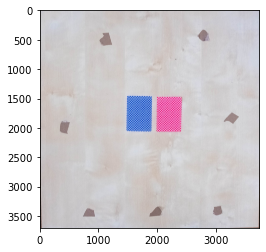

In [24]:
plt.imshow(crop)
plt.show()

### Find origin of markers

In [25]:
idx = [1750,350,400,1900,3350,3350,3320]
row = 200
idy = [3170,2700,1050,300,750,1900,2930]
col = 200

scotch, center_point = [], []
for x,y in zip(idx, idy):
    loc = crop[x:x+row, y:y+col]
    ct = np.array([(x+x+row)//2, (y+y+col)//2])
    scotch.append(loc)
    center_point.append(ct)
    
# isolate cards
idx = 1455
row = 610
idy = 1465
col = 440
card = crop[idx:idx+row, idy:idy+col]
scotch.append(card)
#center_point.append(np.array([(idy+idy+col)//2, (idx+idx+row)//2]))
center_point = np.asarray(center_point, dtype = 'object')

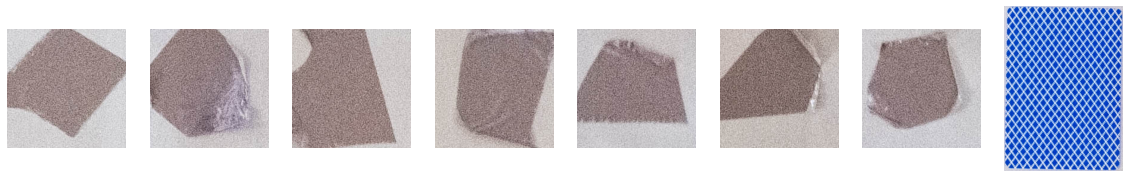

In [26]:
fig, axes = plt.subplots(ncols=8, figsize=(20,6))
for ax, img in zip(axes.flatten(), scotch):
    ax.imshow(img)
    ax.axis('off')
plt.show()

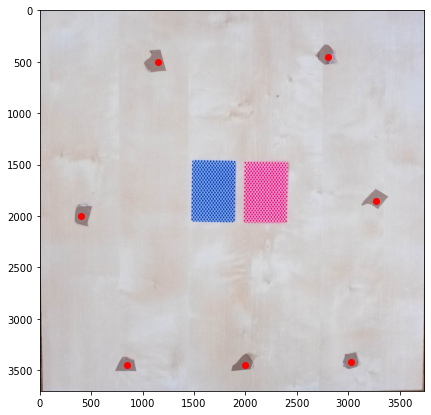

In [27]:
plt.figure(figsize=(10,7))
plt.imshow(crop)
plt.scatter(center_point[:,1], center_point[:,0], color = 'red')
plt.show()

In [28]:
print(f'Rows of table: {crop.shape[0]}')
print(f'Cols of table: {crop.shape[1]}')
# for i, ct in enumerate(center_point[:4]):
#     print(f'Player {i+1} at: {ct}')
# for i, ct in enumerate(center_point[4:]):
#     print(f'Common card {2*i+1} at: {ct}')
print(f'Card dimension: {card.shape[:2]}')

Rows of table: 3701
Cols of table: 3738
Card dimension: (610, 440)


Define the origin of markers and expected card size by a ratio with the table shape (which is supposed to be always the same)

In [29]:
cards_markers = []
for i, ct in enumerate(center_point[:4]):
    print(f'Player {i+1} at {round(ct[0] / crop.shape[0], 3)} % of table rows, {round(ct[1] / crop.shape[1], 3)} % of table cols')
for i, ct in enumerate(center_point[4:]):
    print(f'Common card {2*i+1} at: {round(ct[0] / crop.shape[0], 3)} % of table rows, {round(ct[1] / crop.shape[1], 3)} % of table cols')
print(f'Card dimension: {round(card.shape[0] / crop.shape[0], 3)} % of table rows, {round(card.shape[1] / crop.shape[1], 3)} % of table cols')

Player 1 at 0.5 % of table rows, 0.875 % of table cols
Player 2 at 0.122 % of table rows, 0.749 % of table cols
Player 3 at 0.135 % of table rows, 0.308 % of table cols
Player 4 at 0.54 % of table rows, 0.107 % of table cols
Common card 1 at: 0.932 % of table rows, 0.227 % of table cols
Common card 3 at: 0.932 % of table rows, 0.535 % of table cols
Common card 5 at: 0.924 % of table rows, 0.811 % of table cols
Card dimension: 0.165 % of table rows, 0.118 % of table cols


## Define global markers and use them to find search areas

In [30]:
""" GLOBAL CONSTANTS (SCOTCH MARKERS) """
P1 = [0.5, 0.875]
P2 = [0.122, 0.749]
P3 = [0.135, 0.308]
P4 = [0.54, 0.107]
C1 = [0.932, 0.227]
C2 = [0.932, 0.381]
C3 = [0.932, 0.535]
C4 = [0.932, 0.673]
C5 = [0.924, 0.811]
MARKERS = np.array([P1, P2, P3, P4,
                          C1, C2, C3, C4, C5])
CARD_DIM = [0.165, 0.118]

""" Use global constants in functions """

def find_markers_idx(image):
    table_dim = image.shape[:2]
    return (MARKERS * table_dim).astype(int)

def find_player_search_area(image, marker):
    # adapt search area to table size
    row, col = image.shape[:2]
    R, C = int(row/6), int(col/6)
    x1, x2, y1, y2 = marker[0]-R, marker[0]+R, marker[1]-C, marker[1]+C
    # return a crop on the image
    x1, x2 = np.clip([x1, x2], 0, row)
    y1, y2 = np.clip([y1, y2], 0, col)
    search_area = image[x1:x2, y1:y2]
    return search_area

# def find_common_search_area(image, marker):
#     """TO REFINE"""
#     # adapt card size to table size
#     row, col = image.shape[:2]
#     R, C = int((CARD_DIM[0]*row)/2), int((CARD_DIM[1]*col)/2)
#     x1, x2, y1, y2 = marker[0]-R, marker[0]+R, marker[1]-C, marker[1]+C
#     # return a crop on the image
#     x1, x2 = np.clip([x1, x2], 0, row)
#     y1, y2 = np.clip([y1, y2], 0, col)
#     search_area = image[x1:x2, y1:y2]
#     return search_area

def find_common_search_area(image, markers):
    """ Works but a bit edgy, would be better to rely on something else """
    # isolate a 1rst big search area in bottom 3rd of the image
    row, col = image.shape[:2]
    C = int((CARD_DIM[1]*col))
    start, end = markers[0,1]-C, markers[-1,1]+C
    big_area = image[int(2/3*row):row, start:end]
    
    # refine using edge detector and contours filtering
    edges = edge_detector([big_area])[0]
    contours = contours_by_img([edges])[0]
    contours = filter_contours_by_size([contours], 100, 3000)[0]
    start = np.min([np.min(contour[0,:]) for contour in contours])
    end = np.max([np.max(contour[0,:]) for contour in contours])

    # rescale image and divide in 5
    big_area = big_area[:,start:end]
    w = int(big_area.shape[1]/5)
    cards = [big_area[ : , w*i : w*(1+i) ] for i in range(5)]
    return cards

Player search

In [31]:
idx = 0

In [32]:
markers = find_markers_idx(cropped_img[idx])
player_markers, common_markers = markers[:4], markers[4:]
player_areas = []
for marker in player_markers:
    search_area = find_player_search_area(cropped_img[idx], marker)
    player_areas.append(search_area)

Common search

In [33]:
markers = find_markers_idx(cropped_img[idx])
player_markers, common_markers = markers[:4], markers[4:]
# common_areas = []
# for marker in common_markers:
#     search_area = find_common_search_area(cropped_img[idx], marker)
#     common_areas.append(search_area)
common_areas = find_common_search_area(cropped_img[idx], common_markers)

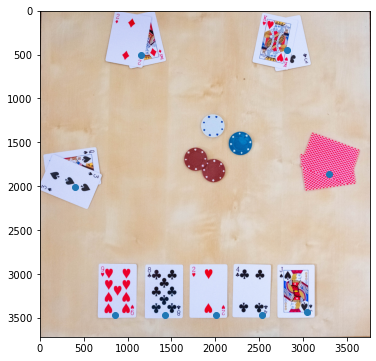

In [34]:
plt.figure(figsize=(6,6))
plt.scatter(markers[:,1], markers[:,0])
plt.imshow(cropped_img[idx])
plt.show()

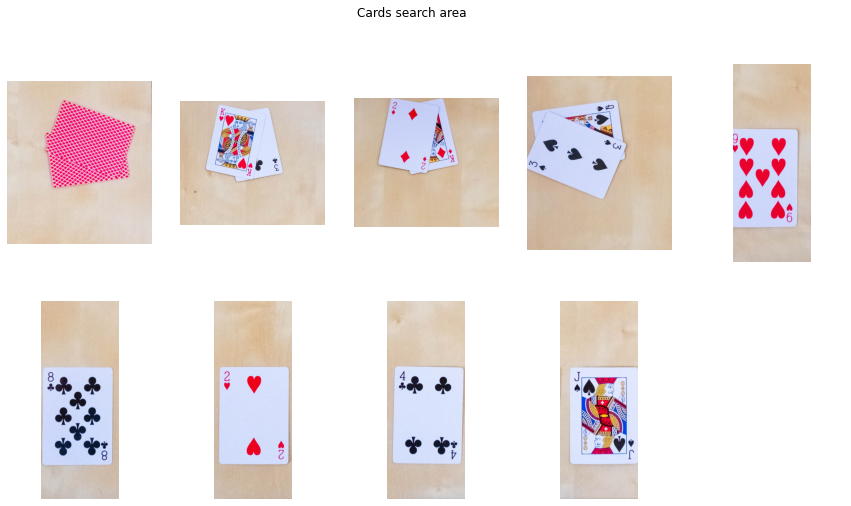

In [35]:
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize=(15,8))
for area, ax in zip(player_areas + common_areas, axes.flatten()):
    ax.imshow(area)
    ax.axis('off')
axes[-1,-1].axis('off')
fig.suptitle('Cards search area')
plt.show()

## Final segmentation routine

In [36]:
""" GLOBAL CONSTANTS (SCOTCH MARKERS) """
P1 = [0.5, 0.875]
P2 = [0.122, 0.749]
P3 = [0.135, 0.308]
P4 = [0.54, 0.107]
C1 = [0.932, 0.227]
C2 = [0.932, 0.381]
C3 = [0.932, 0.535]
C4 = [0.932, 0.673]
C5 = [0.924, 0.811]
MARKERS = np.array([P1, P2, P3, P4,
                          C1, C2, C3, C4, C5])
CARD_DIM = [0.165, 0.118]

In [37]:
test_image = images[2]

crop table and define markers on it

In [38]:
_, crop = cropping_routine(test_image)
markers = find_markers_idx(crop)
player_markers, common_markers = markers[:4], markers[4:]

isolate player areas

In [39]:
player_areas = []
for marker in player_markers:
    search_area = find_player_search_area(crop, marker)
    player_areas.append(search_area)

isolate common cards areas

In [40]:
common_areas = find_common_search_area(crop, common_markers)

(verify result)

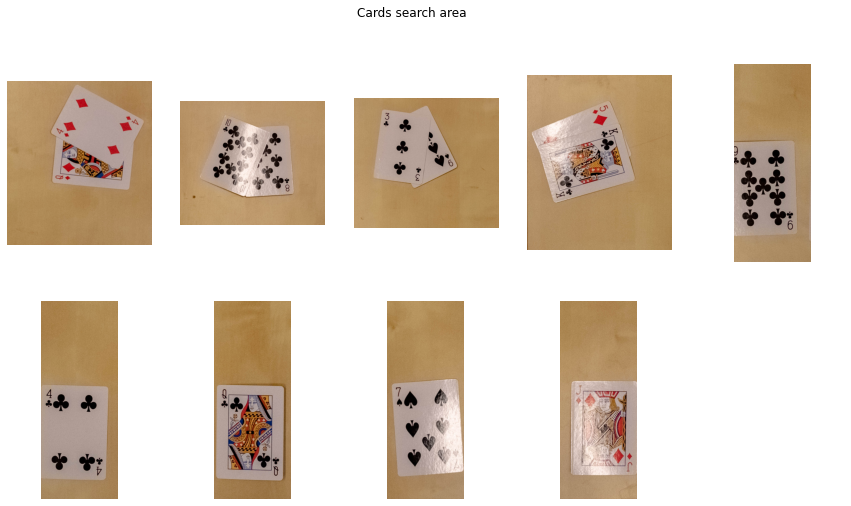

In [41]:
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize=(15,8))
for area, ax in zip(player_areas + common_areas, axes.flatten()):
    ax.imshow(area)
    ax.axis('off')
axes[-1,-1].axis('off')
fig.suptitle('Cards search area')
plt.show()

treat areas independently (work to be done to differentiate pairs of cards)

### (Simple sobel on equalized image) (unused)

In [42]:
sobel = edge_detector(equalized)

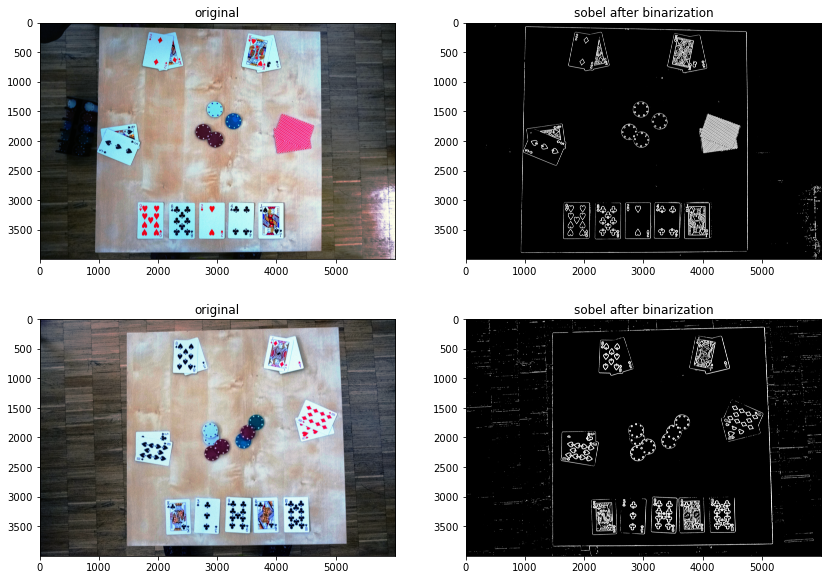

In [43]:
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize=(14,10))
for ax, image, edge in zip(axes, equalized, sobel):
    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('original')
    ax[1].imshow(edge, cmap=plt.cm.gray)
    ax[1].set_title('sobel after binarization')
plt.show()

## OTHER TRIALS

In [44]:
#crops = remove_background(images)

# plt.figure(figsize=(10,6))
# plt.imshow(crops[0])
# plt.axis('off')
# plt.title('Cropped image')
# plt.show()

# plt.figure(figsize=(10,6))
# plt.imshow(crops[1])
# plt.axis('off')
# plt.title('Cropped image')
# plt.show()

# fig, axes = plt.subplots(ncols = 7, nrows = 4, figsize=(20,20))
# for ax, image in zip(axes.flatten(), crops):
#     ax.imshow(image, cmap=plt.cm.gray)
# plt.show()

Current trial: use saturation and hue to create cards contours, which will define where we should look for letters, symbols,...

In [45]:
# img_regions = []
# for image in images:
# #     grayscale = skimage.color.rgb2gray(image)
# #     smoothed = filters.gaussian(grayscale, sigma = 3)
    
# #     gaus_1 = filters.gaussian(smoothed, sigma = 5)
# #     gaus_2 = filters.gaussian(smoothed, sigma = 7)
# #     dog = gaus_2 - gaus_1
    
# #     otsu = filters.threshold_otsu(dog)
# #     output = dog > otsu/2
# #     edges.append(regions)
    
    
# #     labeled_img = skimage.measure.label(image)
# #     labeled.append(labeled_img)
    
    
#     # grayscale = skimage.color.rgb2gray(image)
#     # grayscale = filters.median(grayscale)
#     # fill_img = flood_fill(grayscale, (50, 50), 0, tolerance = 0.1)
#     # filled.append(fill_img)
    
#     #grayscale = skimage.color.rgb2gray(image)
#     #channel = filters.gaussian(channel, sigma = 1)
#     #thresholds = filters.threshold_multiotsu(image=image_hue, classes = 2)
#     #regions_1 = np.digitize(image_hue, bins=thresholds)
    
#     #channel = filters.gaussian(channel, sigma = 1)
#     #thresholds = filters.threshold_multiotsu(image=image_blue, classes = 2)
#     #regions_2 = np.digitize(image_blue, bins=thresholds)
    
#     # Using the threshold values, we generate the regions.
#     #img_regions.append(regions_1 + (255-regions_2))
    
# fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize=(14,10))
# for ax, image, reg in zip(axes, images, img_regions):
#     ax[0].imshow(image, cmap=plt.cm.gray)
#     ax[0].set_title('original')
#     ax[1].imshow(reg, cmap=plt.cm.gray)
#     ax[1].set_title('combination of hue and saturation filtering')
# plt.show()

In [46]:
# plt.figure(figsize=(15,10))
# plt.imshow(img_regions[0], cmap=plt.cm.gray)
# plt.axis('off')
# plt.title('combination of hue and saturation filtering')
# plt.show()

# plt.figure(figsize=(15,10))
# plt.imshow(img_regions[1], cmap=plt.cm.gray)
# plt.axis('off')
# plt.title('combination of hue and saturation filtering')
# plt.show()

Sobel trials on Hue

In [47]:
#from skimage.morphology import closing, opening, disk, square

In [48]:
# fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize=(14,10))
# for i, (ax, hue) in enumerate(zip(axes, images_hsv)):
#     ax[0].imshow(images_hsv[i][:,:,0], cmap = plt.cm.gray)
#     ax[0].set_title('grayscale')
    
#     # sobel
#     sob = filters.sobel(images_hsv[i][:,:,0])
#     otsu = filters.threshold_otsu(sob)
#     output = sob < otsu
#     output = sob
    
#     ax[1].imshow(output, cmap=plt.cm.gray)
#     ax[1].set_title('sobel after binarization')

# plt.show()

In [49]:
path_data = 'data/image_setup/'

cards = path_data + 'spades_suits.jpg'
kings = path_data + 'kings.jpg'
paths = [cards, kings]
cards, kings= load_data(paths)

_, numbers, symbols = isolate_card_features(cards, kings)
all_images = numbers + symbols

In [50]:
edges = edge_detector(all_images)
GT_contours = one_contour_by_img(edges)

In [51]:
contours_len = [len(contour) for contour in GT_contours]

min_size, max_size = np.min(contours_len), np.max(contours_len)
tol_down, tol_up = 20, 20
cont_range = [min_size-tol_down, max_size+tol_up]

#LOWER_BOUND = cont_range[0]
#UPPER_BOUND = cont_range[1]

In [52]:
N = 10
GT_descr = n_FT_descr(complex_contours(GT_contours), N)

In [53]:
descr_1 = GT_descr[:,1]
descr_2 = GT_descr[:,2]
descr_3 = GT_descr[:,3]
descr_4 = GT_descr[:,4]
descr_5 = GT_descr[:,5]
descr_6 = GT_descr[:,6]
descr_7 = GT_descr[:,7]
descr_8 = GT_descr[:,8]
descr_9 = GT_descr[:,9]

GT_descr = np.vstack([descr_1,descr_2,descr_3,
                        descr_4,descr_5,descr_6,
                        descr_7,descr_8,descr_9]).T
#np.save('GT_descr', GT_descr, allow_pickle = True)

In [54]:
# GT_3D_descr = np.load('GT_descr', allow_pickle = True)

""" NUMBER OF FOURIER FEATURES """
N = 10


""" LENGTH LIMITS OF CONTOURS  """
LOWER_BOUND = cont_range[0]
UPPER_BOUND = cont_range[1]


""" SCOTCH MARKERS AND CARD DIMENSION (ratio to table size) """
P1 = [0.5, 0.875]
P2 = [0.122, 0.749]
P3 = [0.135, 0.308]
P4 = [0.54, 0.107]
C1 = [0.932, 0.227]
C2 = [0.932, 0.381]
C3 = [0.932, 0.535]
C4 = [0.932, 0.673]
C5 = [0.924, 0.811]

MARKERS = np.array([P1, P2, P3, P4,
                    C1, C2, C3, C4, C5])
CARD_DIM = [0.165, 0.118]


""" Keys corresponding to features """
NUMBER_KEYS = np.array(['K', 'Q', 'J', '10', '9',
                        '8', '7', '6', '5', '4',
                                '3', '2', 'A'])
SYMBOL_KEYS = np.array(['C', 'S', 'D', 'H'])



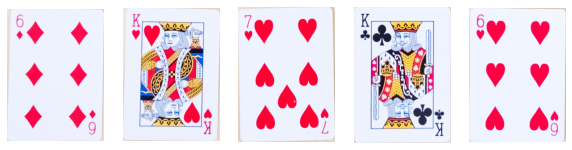

In [66]:
CARD_DIM = [0.165, 0.118]
MARKERS = np.array([P1, P2, P3, P4,
                    C1, C2, C3, C4, C5])
_, table = cropping_routine(images[3])
markers = find_markers_idx(table, MARKERS)
player_markers, common_markers = markers[:4], markers[4:]
cards = find_5_cards(table, common_markers, CARD_DIM)

fig, axes = plt.subplots(ncols = len(cards), figsize=(10,6))
for ax, image in zip(axes.flatten(),cards):
    ax.imshow(image)
    ax.axis('off')
plt.show()

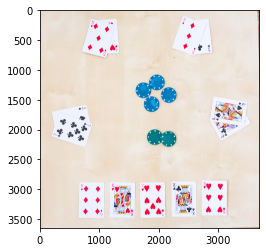

In [67]:
plt.imshow(table)

In [64]:
# instantiate results
results = {"T1": 0, "T2": 0, "T3": 0, "T4": 0, "T5": 0,
            "P11": 0 , "P12": 0, "P21": 0, "P22": 0,
            "P31": 0,"P32":0 , "P41": 0, "P42": 0,
             "CR": 0, "CG": 0, "CB": 0,"CK": 0, "CW": 0}

# crop table out of image and recuperate scotch markers
_, table = cropping_routine(images[3])
markers = find_markers_idx(table, MARKERS)
player_markers, common_markers = markers[:4], markers[4:]

# separate player areas for feature search using markers
player_areas = []
for marker in player_markers:
    search_area = find_player_search_area(table, marker)
    player_areas.append(search_area)

# separate common cards areas for feature search using markers
""" still to implement and use correctly """
common_areas = find_5_cards(table, common_markers, CARD_DIM)
areas=player_areas+common_areas
""""""""""""""""""""""""""""""""""""

# create Fourier features for each area (DO AT SAME TIME AS COMMON_AREAS)
edges = edge_detector(common_areas)
is_back_of_card = check_if_back(edges, LOWER_BOUND, UPPER_BOUND)
contours = contours_by_img(edges)
filt_contours = filter_contours_by_size(contours, LOWER_BOUND, UPPER_BOUND)
cards_comp_ct = [complex_contours(card_cont) for card_cont in filt_contours]
areas_descr = [n_FT_descr(comp_ct, N) for comp_ct in cards_comp_ct]

""" Make a function out of this """
selected_descr = []
for descriptors, is_back in zip(areas_descr, is_back_of_card):
    if not is_back:
        descr_1 = descriptors[:,1]
        descr_2 = descriptors[:,2]
        descr_3 = descriptors[:,3]
        descr_4 = descriptors[:,4]
        descr_5 = descriptors[:,5]
        descr_6 = descriptors[:,6]
        descr_7 = descriptors[:,7]
        descr_8 = descriptors[:,8]
        descr_9 = descriptors[:,9]
        descr = np.vstack([descr_1,descr_2,descr_3,
                            descr_4,descr_5,descr_6,
                            descr_7,descr_8,descr_9]).T
    else: descr = np.zeros(9)
    selected_descr.append(descr)
""""""""""""""""""""""""""""""""""""
"""
# find player cards and write in results
cards = ['P11', 'P12', 'P21', 'P22', 'P31', 'P32', 'P42', 'P41']
for i in range(4):
    down_or_right, up_or_left = player_pred(selected_descr[i], filt_contours[i],
                                            GT_descr, 4-i, NUMBER_KEYS, SYMBOL_KEYS)
    results[cards[2*i]] = down_or_right
    results[cards[2*i + 1]] = up_or_left

# find common cards and write in results
common_cards = ["T1", "T2", "T3", "T4", "T5"]
for i in range(4,9):
    results[common_cards[i-4]] =predict_cards_from_predictors(selected_descr[i], GT_descr, NUMBER_KEYS, SYMBOL_KEYS)
pred_numbers = []
# chips evaluation
"""   
chips_area = find_chips_search_area(table)
pred,final_mask = predict_chips_area(chips_area)
final_mask = opening(final_mask, disk(4))

color = give_color(chips_area,final_mask)


results["CR"] = n_chips(np.sum(color==3),final_mask) #red 
results["CG"] = n_chips(np.sum(color==5),final_mask) #green
results["CB"] = n_chips(np.sum(color==4),final_mask) #blue
results["CK"] = n_chips(np.sum(color==1),final_mask) #black

white = np.sum(color==2) - 0.05*(np.sum(color==1)+np.sum(color==4)+np.sum(color==3)+np.sum(color==5))

results["CW"] = n_chips(white,final_mask) #white


In [64]:
for i in range (len(selected_descr)):
    print(len(selected_descr[i]))
    print(";")

9
;
9
;
9
;


TypeError: object of type 'numpy.float64' has no len()

In [66]:
for i in range(len(selected_descr)):
    print(len(selected_descr[i]))

5
12
12
9
4


In [65]:
len(selected_descr)

5

In [61]:
common_cards = ["T1", "T2", "T3", "T4", "T5"]
for i in range(4,9):
    results[common_cards[i-4]]='AS'
    

In [62]:
pred_numbers, pred_symbols = predict_cards_from_predictors(selected_descr, GT_descr, NUMBER_KEYS, SYMBOL_KEYS)

AxisError: axis 1 is out of bounds for array of dimension 1

In [63]:
GT_descr.shape[0]

17

In [65]:
predictors = get_predictors(common_areas, LOWER_BOUND, UPPER_BOUND)
pred_numbers, pred_symbols = predict_cards_from_predictors(predictors, GT_descr, NUMBER_KEYS, SYMBOL_KEYS)

ValueError: too many values to unpack (expected 2)

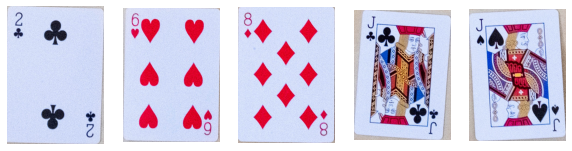

In [70]:
fig, axes = plt.subplots(ncols = len(common_areas), figsize=(10,6))
for ax, image in zip(axes.flatten(),common_areas):
    ax.imshow(image)
    ax.axis('off')
plt.show()

In [73]:
final =[]
for num, sym in zip(pred_numbers, pred_symbols):
    final.append(num+sym)

In [74]:
final

['8C', '9H', '8D', 'JC', 'JS']